**Lưu ý** (27/12/2024): 

- Vấn đề không tương thích giữa phiên bản Scikit-learn và XGBoost do thay đổi trong API của Scikit-learn. Nguồn: [stackoverflow](https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags), [github](https://github.com/dmlc/xgboost/pull/11021).

- Phương án xử lý: Sử dụng phiên bản cũ hơn của hai thư viện này.

    ```bash
    pip uninstall -y scikit-learn xgboost
    pip install -q scikit-learn==1.5.2 xgboost==1.7.4
    ```

In [21]:
# !pip uninstall -y scikit-learn xgboost
# !pip install -q scikit-learn==1.5.2 xgboost==1.7.4

In [22]:
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Xử lý dữ liệu
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Mô hình hồi quy
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

# Đánh giá mô hình
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Thiết lập tùy chọn hiển thị số quá dài
pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# **1. Đọc dữ liệu**

In [23]:
# Hiển thị vài dòng đầu tiên của DataFrame để xem nhanh về dữ liệu
df = pd.read_csv('data_model.csv')
df.head()

,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,job_simplified,seniority,Rating Category,job_state,Python_yn,Spark,AWS_yn,Average Salary
0,Tecolote Research,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),data scientist,Other,Medium Rating,NM,1,0,0,7.200e+04
1,University of Maryland Medical System,"Linthicum, MD","Baltimore, MD",10000+ employees,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),data scientist,Other,Medium Rating,MD,1,0,0,8.750e+04
2,KnowBe4,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,Company - Private,Security Services,Business Services,$100 to $500 million (USD),data scientist,Other,High Rating,FL,1,1,0,8.500e+04
3,PNNL,"Richland, WA","Richland, WA",1001 to 5000 employees,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),data scientist,Other,Medium Rating,WA,1,0,0,7.650e+04
4,Affinity Solutions,"New York, NY","New York, NY",51 to 200 employees,Company - Private,Advertising & Marketing,Business Services,Unknown,data scientist,Other,Low Rating,NY,1,0,0,1.145e+05


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company Name       742 non-null    object 
 1   Location           742 non-null    object 
 2   Headquarters       742 non-null    object 
 3   Size               742 non-null    object 
 4   Type of ownership  742 non-null    object 
 5   Industry           742 non-null    object 
 6   Sector             742 non-null    object 
 7   Revenue            742 non-null    object 
 8   job_simplified     742 non-null    object 
 9   seniority          742 non-null    object 
 10  Rating Category    742 non-null    object 
 11  job_state          742 non-null    object 
 12  Python_yn          742 non-null    int64  
 13  Spark              742 non-null    int64  
 14  AWS_yn             742 non-null    int64  
 15  Average Salary     742 non-null    float64
dtypes: float64(1), int64(3), o

In [25]:
df.describe()

,Python_yn,Spark,AWS_yn,Average Salary
count,7.420e+02,7.420e+02,7.420e+02,7.420e+02
mean,5.283e-01,2.251e-01,2.372e-01,1.015e+05
std,4.995e-01,4.179e-01,4.257e-01,3.746e+04
min,0.000e+00,0.000e+00,0.000e+00,1.550e+04
25%,0.000e+00,0.000e+00,0.000e+00,7.350e+04
50%,1.000e+00,0.000e+00,0.000e+00,9.750e+04
75%,1.000e+00,0.000e+00,0.000e+00,1.225e+05
max,1.000e+00,1.000e+00,1.000e+00,2.540e+05


In [26]:
df[df.duplicated()]

,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,job_simplified,seniority,Rating Category,job_state,Python_yn,Spark,AWS_yn,Average Salary
29,KnowBe4,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,Company - Private,Security Services,Business Services,$100 to $500 million (USD),data scientist,Other,High Rating,FL,1,1,0,8.500e+04
30,PNNL,"Richland, WA","Richland, WA",1001 to 5000 employees,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),data scientist,Other,Medium Rating,WA,1,0,0,7.650e+04
58,ClearOne Advantage,"Baltimore, MD","Baltimore, MD",501 to 1000 employees,Company - Private,Banks & Credit Unions,Finance,Unknown,data scientist,Other,High Rating,MD,0,0,0,7.350e+04
59,CyrusOne,"Dallas, TX","Dallas, TX",201 to 500 employees,Company - Public,Real Estate,Real Estate,$1 to $2 billion (USD),data scientist,Other,Medium Rating,TX,1,0,1,9.500e+04
86,Walmart,"Plano, TX","Bentonville, AR",10000+ employees,Company - Public,"Department, Clothing, & Shoe Stores",Retail,$10+ billion (USD),data scientist,Associate,Medium Rating,TX,0,0,0,1.390e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,GSK,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,Company - Public,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$10+ billion (USD),other scientist,Senior/Principal,Medium Rating,MA,0,0,1,8.450e+04
738,Eventbrite,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,Company - Public,Internet,Information Technology,$100 to $500 million (USD),data engineer,Senior/Principal,High Rating,TN,1,1,1,1.025e+05
739,Software Engineering Institute,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,College / University,Colleges & Universities,Education,Unknown,other scientist,Entry Level,Low Rating,PA,0,0,0,7.350e+04
740,"Numeric, LLC","Allentown, PA","Chadds Ford, PA",1 to 50 employees,Company - Private,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),data scientist,Senior/Principal,Medium Rating,PA,0,0,0,1.275e+05


# **2. Train - Test Split**

In [27]:
X = df.drop('Average Salary', axis=1)
y = df['Average Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước y_train: {y_train.shape}")
print(f"Kích thước X_test: {X_test.shape}")
print(f"Kích thước y_test: {y_test.shape}")

Kích thước X_train: (593, 15)
Kích thước y_train: (593,)
Kích thước X_test: (149, 15)
Kích thước y_test: (149,)


# **3. Lựa chọn mô hình cho dữ liệu**

In [28]:
def create_regression_pipeline(model_name):
    """
    Tạo pipeline chỉ chứa một mô hình hồi quy cụ thể.

    Parameters:
        - model_name (str): Tên của mô hình hồi quy.

    Returns:
        - dict: Dictionary chứa tên mô hình và pipeline tương ứng đã tạo.
    """
    regression_models = {
        'SVR': SVR(),
        'XGBoost': XGBRegressor(random_state=42),
        'KNeighbors': KNeighborsRegressor(),
        'DecisionTree': DecisionTreeRegressor(random_state=42),
        'RandomForest': RandomForestRegressor(random_state=42),
        'LinearRegression': LinearRegression(),
        'HistogramGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    }

    # Xử lý dữ liệu
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features   = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) # Sửa đổi OneHotEncoder để tạo ra đầu ra dense
        ]
    )

    # Tạo pipeline
    regression_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regression_models[model_name])
    ])

    pipeline_dict = {model_name: regression_pipeline}
    return pipeline_dict

def create_all_regression_pipelines():
    """
    Tạo tất cả các pipeline cho các mô hình hồi quy sử dụng.

    Returns:
        - dict: Dictionary chứa tất cả tên mô hình và pipeline tương ứng đã tạo.
    """
    regression_model_names = [
        'RandomForest', 'SVR', 'LinearRegression',
        'KNeighbors', 'DecisionTree', 'XGBoost', 'HistogramGradientBoosting'
    ]

    all_pipelines = {}
    for model_name in regression_model_names:
        pipeline_dict = create_regression_pipeline(model_name)
        all_pipelines.update(pipeline_dict)
        
    return all_pipelines

def train_evaluate_model_with_df(model_name, model, X_train, y_train, X_test, y_test, results_df):
    """
    Huấn luyện mô hình, đánh giá hiệu suất và lưu kết quả vào DataFrame.

    Parameters:
        - model_name       (str): Tên mô hình.
        - model                 : Mô hình đã được khởi tạo.
        - X_train    (DataFrame): Dữ liệu huấn luyện.
        - y_train       (Series): Nhãn của dữ liệu huấn luyện.
        - X_test     (DataFrame): Dữ liệu kiểm thử.
        - y_test        (Series): Nhãn của dữ liệu kiểm thử.
        - results_df (DataFrame): DataFrame để lưu trữ kết quả.

    Returns:
        - DataFrame: DataFrame kết quả sau khi thêm thông tin của mô hình hiện tại.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Đánh giá hiệu suất
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Tạo DataFrame từ kết quả và concatenate vào DataFrame kết quả chung
    model_results = pd.DataFrame({
        'Mô hình': [model_name], 
        'MSE': mse, 
        'MAE': mae, 
        'R2': r2
    })
    results_df = pd.concat([results_df, model_results], ignore_index=True)

    return results_df

def run_pipelines_with_metrics_to_dataframe(all_pipelines, X_train, y_train, X_test, y_test):
    """
    Huấn luyện và đánh giá tất cả các mô hình trong danh sách pipelines và lưu kết quả vào DataFrame

    Parameters:
        - all_pipelines (dict): Dictionary chứa tên và pipeline của các mô hình.
        - X_train  (DataFrame): Dữ liệu huấn luyện.
        - y_train     (Series): Nhãn của dữ liệu huấn luyện.
        - X_test   (DataFrame): Dữ liệu kiểm thử.
        - y_test      (Series): Nhãn của dữ liệu kiểm thử.

    Returns:
        - DataFrame: DataFrame chứa kết quả hiệu suất của tất cả các mô hình.
    """
    results_df = pd.DataFrame(columns=['Mô hình', 'MSE', 'MAE', 'R2'])

    for model_name, pipeline in all_pipelines.items():
        results_df = train_evaluate_model_with_df(
            model_name, pipeline, 
            X_train, y_train, X_test, y_test, 
            results_df
        )

    # Sắp xếp DataFrame theo thứ tự giảm dần của R2
    results_df = results_df.sort_values(
        by='R2', 
        ascending=False
    ).reset_index(drop=True)

    return results_df

In [29]:
all_pipelines = create_all_regression_pipelines()
results_df    = run_pipelines_with_metrics_to_dataframe(all_pipelines, X_train, y_train, X_test, y_test)
results_df

C:\Users\nguye\AppData\Local\Temp\ipykernel_10540\2277151638.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, model_results], ignore_index=True)


,Mô hình,MSE,MAE,R2
0,XGBoost,2.687e+08,1.065e+04,8.286e-01
1,RandomForest,2.936e+08,1.127e+04,8.127e-01
2,HistogramGradientBoosting,4.009e+08,1.456e+04,7.443e-01
3,DecisionTree,4.605e+08,1.024e+04,7.062e-01
4,KNeighbors,8.300e+08,2.173e+04,4.706e-01
5,SVR,1.616e+09,3.117e+04,-3.078e-02
6,LinearRegression,2.511e+33,1.946e+16,-1.602e+24


**Nhận xét**: Ta thấy trong số các mô hình đã chọn thì XGBoost cho hiệu suất tốt nhất, nên ta chọn mô hình này để tiến hành các bước tiếp theo.

# **4. Chạy XGBoost với tham số mặc định**

In [30]:
xgb_res = XGBRegressor()

# Xem các tham số mặc định
default_params = xgb_res.get_params()

# Chọn ra các tham số quan tâm
desired_params          = ['reg_lambda', 'reg_alpha', 'n_estimators', 'max_depth', 'learning_rate', 'gamma', 'colsample_bytree']
selected_default_params = {param: default_params[param] for param in desired_params}

default_params_df = pd.DataFrame([selected_default_params])
default_params_df = default_params_df.transpose()
default_params_df.columns = ['Value']

print("Các tham số mặc định của XGBRegressor:")
default_params_df

Các tham số mặc định của XGBRegressor:


,Value
reg_lambda,None
reg_alpha,None
n_estimators,100
max_depth,None
learning_rate,None
gamma,None
colsample_bytree,None


In [31]:
# Xử lý dữ liệu
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features   = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) # Sửa đổi OneHotEncoder để tạo ra đầu ra dense
    ]
)

# Tạo pipeline
xgb_res = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

# Huấn luyện và kiểm tra, đánh giá
xgb_res.fit(X_train, y_train)
y_pred = xgb_res.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2) Score: {r2:.3f}")

Mean Squared Error (MSE): 268723315.569
Mean Absolute Error (MAE): 10650.671
R-squared (R2) Score: 0.829


# **5. Tuning cho XGBoost**

In [32]:
params = {
    # "n_estimators": Số lần lặp của quá trình boosting.
    "n_estimators": range(100, 500, 50),

    # "learning_rate": Tỉ lệ học, giảm trọng số để làm cho quá trình boosting thêm thận trọng.
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],

    # "max_depth": Độ sâu tối đa của cây, ảnh hưởng đến độ phức tạp của mô hình.
    "max_depth": range(3, 21, 3),

    # "gamma": Điều chỉnh mức giảm tổn thất tối thiểu để thực hiện một phân chia.
    "gamma": [i / 10.0 for i in range(0, 5)],

    # "colsample_bytree": Phần trăm cột được lấy mẫu ngẫu nhiên cho mỗi cây.
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],

    # "reg_alpha": Chế độ chính quy L1, giảm overfitting và làm mô hình thêm thận trọng.
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],

    # "reg_lambda": Chế độ chính quy L2, giảm overfitting và làm mô hình thêm thận trọng.
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]
}

# Tạo và huấn luyện mô hình tinh chỉnh cho XGBoost Regressor
rs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',RandomizedSearchCV(XGBRegressor(),params,n_iter=50,verbose=3,random_state=42))
])
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-8.627 total time=   0.5s
[CV 2/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-6.897 total time=   0.6s
[CV 3/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-5.408 total time=   0.5s
[CV 4/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-8.500 total time=   0.5s
[CV 5/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-7.010 total time=   0.5s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=1, max_depth=18, n_estimators=450, reg_alpha=1, reg_lambda=100;

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Python_yn', 'Spark',
                                                   'AWS_yn']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Company Name', 'Location',
                                                   'Headquarters', 'Size',
                                                   'Type of ownership',
                                                   'Industry', 'Sector',
                                                   'Revenue', 'job_simplified',
                                                   'seniority',
                                                   'Rating Category',
                                                   'job_state'])])),
                ('mod...
                                                           predictor=None,
                                                           random_state=None, ...),
                                    n_iter=50,
                                    param_distributions={'colsample_bytree': [0.3,
                                                                              0.4,
                                                                              0.5,
                                                                              0.6,
                                                                              0.7,
                                                                              0.8,
                                                                              0.9],
                                                         'gamma': [0.0, 0.1,
                                                                   0.2, 0.3,
                                                                   0.4],
                                                         'learning_rate': [0.0001,
                                                                           0.001,
                                                                           0.01,
                                                                           0.1,
                                                                           1],
                                                         'max_depth': range(3, 21, 3),
                                                         'n_estimators': range(100, 500, 50),
                                                         'reg_alpha': [1e-05,
                                                                       0.01,
                                                                       0.1, 1,
                                                                       10,
                                                                       100],
                                                         'reg_lambda': [1e-05,
                                                                        0.01,
                                                                        0.1, 1,
                                                                        10,
                                                                        100]},
                                    random_state=42, verbose=3))])

In [33]:
random_search = rs.named_steps['model']
print(f'Điểm số tốt nhất: {random_search.best_score_:.3f}')

best_params_df = pd.DataFrame([random_search.best_params_]).transpose()
best_params_df.columns = ['Value']
print('Các tham số tốt nhất:')
print(best_params_df)

Điểm số tốt nhất: 0.727
Các tham số tốt nhất:
                     Value
reg_lambda       1.000e-05
reg_alpha        1.000e+00
n_estimators     4.500e+02
max_depth        1.800e+01
learning_rate    1.000e-01
gamma            4.000e-01
colsample_bytree 4.000e-01


In [34]:
random_search = rs.named_steps['model']
results_df = pd.DataFrame(random_search.cv_results_)

# Lựa chọn các cột quan trọng cho phân tích
selected_columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
results_df = results_df[selected_columns]

# Sắp xếp DataFrame dựa trên rank_test_score theo thứ tự tăng dần
results_df = results_df.sort_values(by='rank_test_score')

# Lưu trữ kết quả
output_dir = '../tuning'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_path = os.path.join(output_dir, 'RandomSearch_CV_XGBoost_OneHot.csv')
results_df.to_csv(output_path, index=False)

print(f"Kết quả Random Search đã được lưu vào: {output_path}")

Kết quả Random Search đã được lưu vào: ../tuning\RandomSearch_CV_XGBoost_OneHot.csv


# **6. Đánh giá mô hình với tham số tốt nhất**

## **6.1. Train - Test Split**

In [35]:
# Lấy các tham số tốt nhất ở dòng đầu tiên của file kết quả tuning
xgb_rscv = pd.read_csv("../tuning/RandomSearch_CV_XGBoost_OneHot.csv")
best_params = ast.literal_eval(xgb_rscv['params'][0])

# Sử dụng XGBRegressor với các tham số tốt nhất
xgb_best = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',XGBRegressor(**best_params))
])

xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2) Score: {r2:.3f}")

Mean Squared Error (MSE): 248466344.827
Mean Absolute Error (MAE): 7420.090
R-squared (R2) Score: 0.842


## **6.2. Cross Validation (K-Fold)**

In [36]:
# Sử dụng KFold với 10 folds và hoán đổi dữ liệu trước mỗi lần chia
kf = KFold(n_splits=10, shuffle=True, random_state=42)

mses = []
maes = []
r2s = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i + 1}:") 

    xgb_best.fit(X.iloc[train_index], y.iloc[train_index])
    y_pred = xgb_best.predict(X.iloc[test_index])

    mse = mean_squared_error(y.iloc[test_index], y_pred)
    mae = mean_absolute_error(y.iloc[test_index], y_pred)
    r2 = r2_score(y.iloc[test_index], y_pred)

    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"R-squared (R2) Score: {r2:.3f}")
    print()

    mses.append(mse)
    maes.append(mae)
    r2s.append(r2)

# Tính toán và in ra giá trị trung bình của các độ đo trên tất cả các fold
mean_mse = sum(mses) / len(mses)
mean_mae = sum(maes) / len(maes)
mean_r2 = sum(r2s) / len(r2s)

print(f"Mean MSEs: {mean_mse:.3f}")
print(f"Mean MAEs: {mean_mae:.3f}")
print(f"Mean R2s: {mean_r2:.3f}")

Fold 1:
Mean Squared Error (MSE): 323509244.889
Mean Absolute Error (MAE): 9170.349
R-squared (R2) Score: 0.795

Fold 2:
Mean Squared Error (MSE): 288311970.653
Mean Absolute Error (MAE): 6899.549
R-squared (R2) Score: 0.805

Fold 3:
Mean Squared Error (MSE): 270256278.143
Mean Absolute Error (MAE): 7887.944
R-squared (R2) Score: 0.714

Fold 4:
Mean Squared Error (MSE): 355090927.602
Mean Absolute Error (MAE): 8544.482
R-squared (R2) Score: 0.780

Fold 5:
Mean Squared Error (MSE): 181863423.341
Mean Absolute Error (MAE): 6508.935
R-squared (R2) Score: 0.836

Fold 6:
Mean Squared Error (MSE): 228430120.322
Mean Absolute Error (MAE): 7472.681
R-squared (R2) Score: 0.873

Fold 7:
Mean Squared Error (MSE): 591616426.198
Mean Absolute Error (MAE): 10506.991
R-squared (R2) Score: 0.581

Fold 8:
Mean Squared Error (MSE): 180901631.391
Mean Absolute Error (MAE): 6261.799
R-squared (R2) Score: 0.850

Fold 9:
Mean Squared Error (MSE): 407922399.500
Mean Absolute Error (MAE): 9569.530
R-squared (

## **6.3. Visualization**

In [37]:
def plot_metric_scores(metric_values, metric_name):
    """
    Vẽ biểu đồ cột cho các giá trị của một độ đo cụ thể.

    Parameters:
        - metric_values: Danh sách chứa giá trị của độ đo cho từng fold.
        - metric_name: Tên của độ đo (vd: 'MAE', 'MSE', 'R2').

    Returns:
        None.
    """

    # Tạo biểu đồ cột với metric_values
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(metric_values) + 1), metric_values, color='skyblue')
    plt.xlabel('Fold')
    plt.ylabel(f'Điểm {metric_name}')
    plt.title(f'Điểm {metric_name} cho từng Fold')
    plt.xticks(range(1, len(metric_values) + 1))
    plt.show()

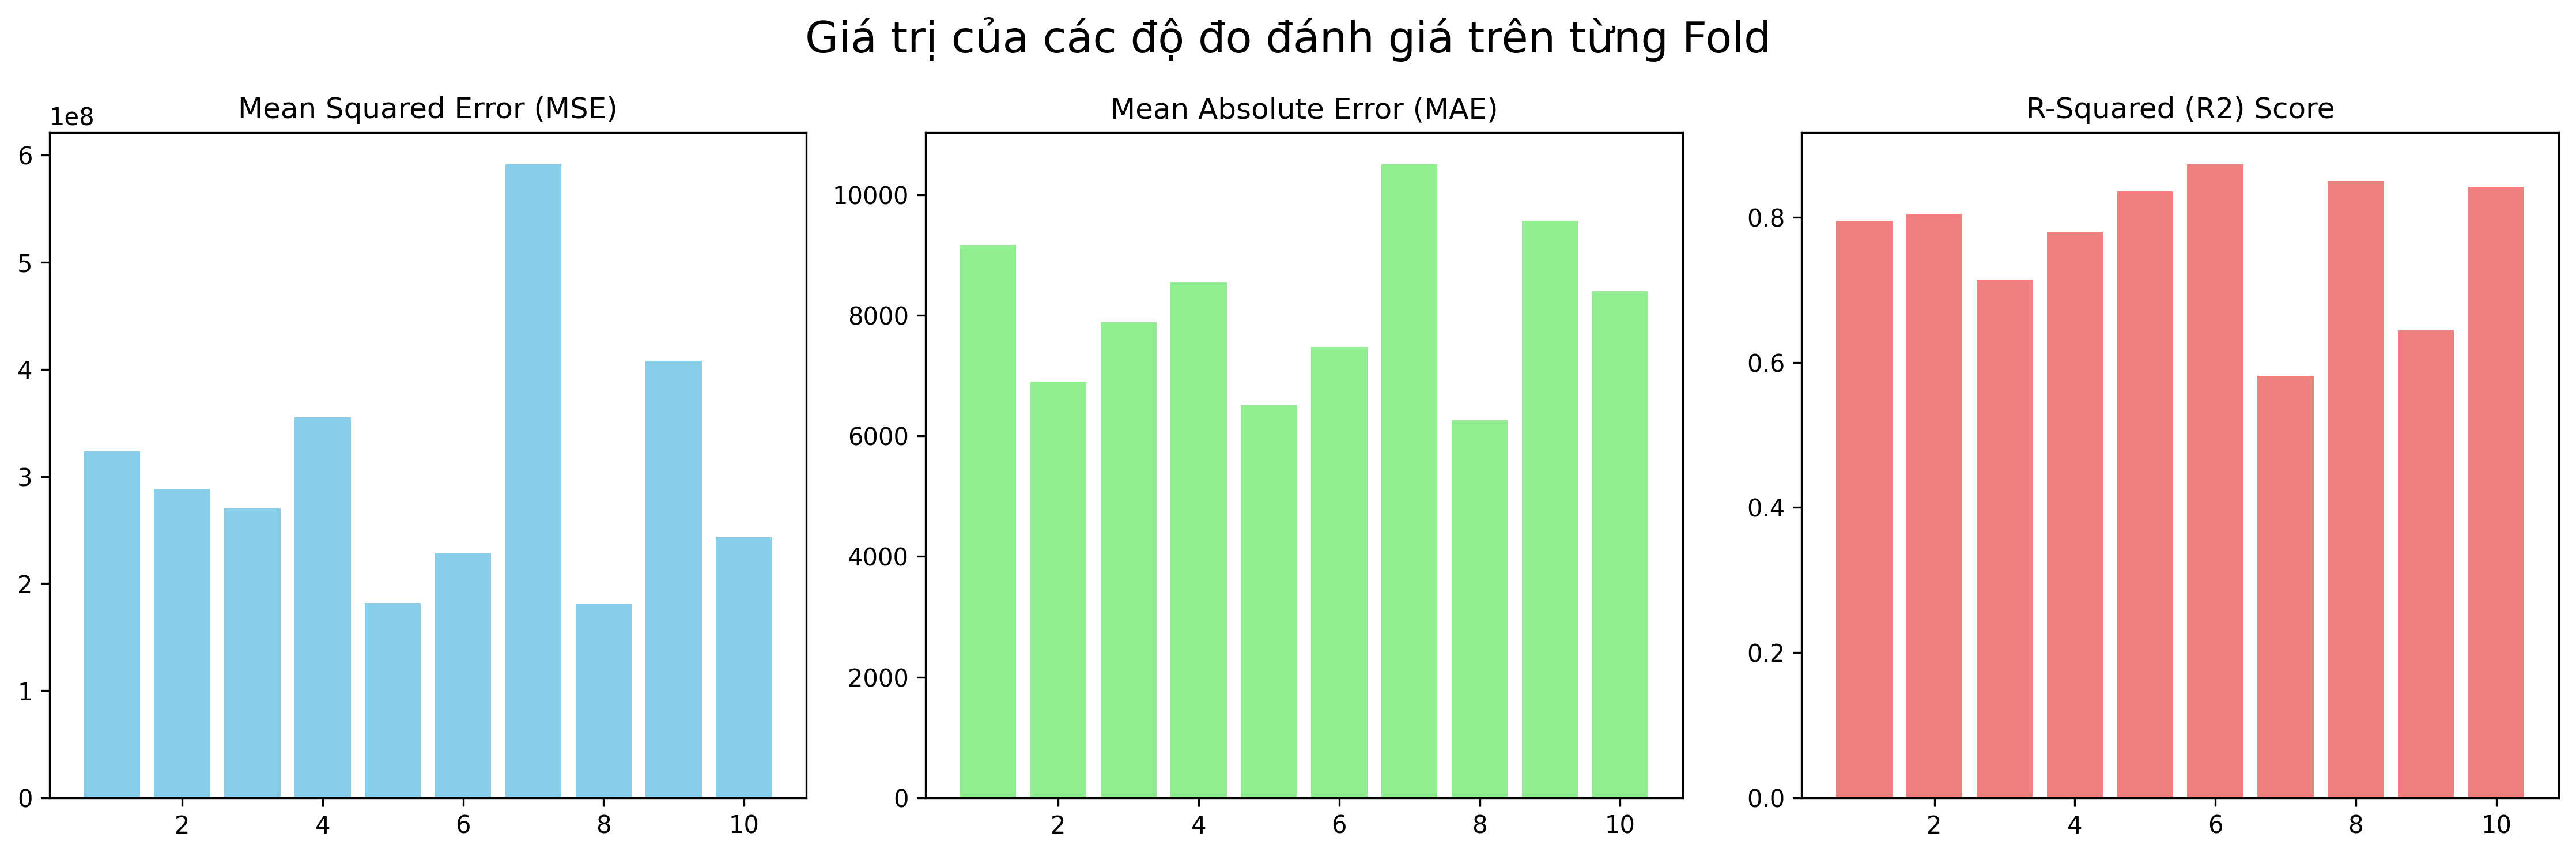

In [38]:
# Tạo figure và axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=300)

# Biểu đồ cho MSE
axes[0].bar(range(1, len(mses) + 1), mses, color='skyblue')
axes[0].set_title('Mean Squared Error (MSE)')

# Biểu đồ cho MAE
axes[1].bar(range(1, len(maes) + 1), maes, color='lightgreen')
axes[1].set_title('Mean Absolute Error (MAE)')

# Biểu đồ cho R2
axes[2].bar(range(1, len(r2s) + 1), r2s, color='lightcoral')
axes[2].set_title('R-Squared (R2) Score')

# Tiêu đề chung cho cả 3 biểu đồ
fig.suptitle("Giá trị của các độ đo đánh giá trên từng Fold", fontsize=18)

# Hiển thị 3 biểu đồ cột trên cùng một hàng
plt.tight_layout()
plt.show()